In [13]:
import pandas as pd
from sklearn import metrics

# read in csv data
matches = pd.read_csv("matches_with_new_features.csv")
team_stats = pd.read_csv("team_stats.csv")

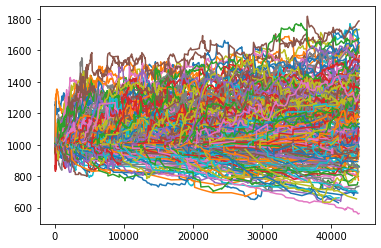

In [14]:
import matplotlib.pyplot as plt

for index, team in team_stats.iterrows():
    # print(team["name"])    
    matches.loc[matches["home_team"] == team["name"], "ELO_home"].plot()


In [19]:
# tried reversing the ELO calc ....does not work good

from K_val import K
from ELO_init import ELOinit

def calcBackELO( R_old, R_opp, tournament_type, own_score, opp_score, is_home_team, neutral):
    # R_new = R_old + K * G * (W - W_e)
    #   R_new = The new team rating
    #   R_old = The old team rating
    #   K = Weight index regarding the tournament of the match
    #       World Cup, Olympic Games (1908–1980) 	60
    #       Continental championship and intercontinental tournaments 	50
    #       World Cup and Continental qualifiers and major tournaments 	40
    #       All other tournaments 	30
    #       Friendly matches 	30
    #   G = A number from the index of goal differences
    #   W = The result of the match
    #   W_e = The expected result
    G=1
    W=1

    # set G according to http://www.eloratings.net/about
    if (own_score >= (opp_score+4)):
        N = own_score-opp_score
        G = 1 + 3/4 + (N-3)/8
    elif (own_score > opp_score+3):
        G = 1.5

    # dr equals the difference in ratings plus 100 points for a team playing at home. 
    if (neutral):
        dr = R_old - R_opp
    elif (is_home_team):
        dr = R_old + 100 - R_opp
    else:
        dr = R_old - (R_opp +100)
    
    # We = 1 / ( (10^(-dr/400)) + 1)
    We = 1 / ( pow(10, (-dr/400)) + 1)

    if (own_score > opp_score):
        W = 1
    elif (own_score ==  opp_score):
        W = 0.5
    else:
        W = 0

    R_new = R_old - K[tournament_type] * G * (W - We)
    
    return R_new


# initialie team_stats
uteams = (matches["home_team"].append( matches["away_team"] )).unique()
team_stats = pd.DataFrame({
                   "index": uteams,
                   "name": uteams,
                   "ELO": 1000.0,
                   "fGoals": 1, # every team starts with fGoals/aGoals score of 1 otherwise the ration would be Inf at the beginning
                   "aGoals": 1, # since the overall goals will be a high value this offset of 1 should influence much
                   "num_matches": 0,
                   "fGoals_p_match": 0.0,
                   "aGoals_p_match": 0.0})
team_stats.set_index("index", inplace = True)

# first import latest ratings from database (eloratings.net)
# init ELO ratings based on eloratings.net
for index, team in team_stats.iterrows():
    # print(team["name"])
    if team["name"] in ELOinit.keys():
        team_stats.at[team["name"], "ELO"] = ELOinit[team["name"]]
    else:
        team["ELO"] = 1000.0

# go backwards in time and update ELO ratings
for ind in matches.sort_index(ascending=False).index:
    ht = matches["home_team"][ind]
    at = matches["away_team"][ind]

    ELO_after_home = team_stats.at[ht, "ELO"]
    ELO_after_away = team_stats.at[at, "ELO"]
    
    # calc new ELO
    Ro_home = calcBackELO(ELO_after_home, ELO_after_away, matches["tournament"][ind], matches["home_score"][ind], matches["away_score"][ind], not matches["neutral"][ind], matches["neutral"][ind])
    Ro_away = calcBackELO(ELO_after_away, ELO_after_home, matches["tournament"][ind], matches["away_score"][ind], matches["home_score"][ind], False, matches["neutral"][ind])
    # Update ELO after match
    team_stats.at[ht, "ELO"] = float(Ro_home)
    team_stats.at[at, "ELO"] = float(Ro_away)

    # get ELO from team_stats DataFrame (before match) and write into matches DataFrame 
    matches.at[ind, "ELO_home"] = Ro_home
    matches.at[ind, "ELO_away"] = Ro_away

<AxesSubplot:>

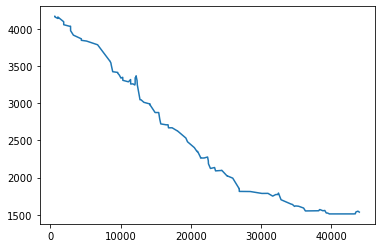

In [22]:
matches.loc[matches["home_team"] == "England", "ELO_home"].plot()